In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

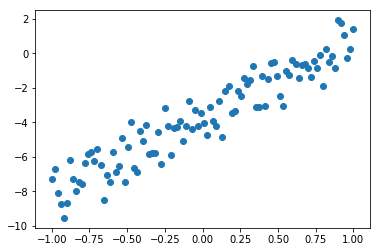

In [108]:
# simulate linear data
x_train = np.linspace(-1, 1, 100)
# y = 4.5 x + 10
y_train = 4.5 * x_train + np.random.randn(x_train.shape[0]) + np.random.randn() * 10

n_samples = x_train.shape[0]

plt.scatter(x_train, y_train)
plt.show()

In [109]:
# place holder for data
X = tf.placeholder(dtype=tf.float32)
Y = tf.placeholder(dtype=tf.float32)

# create variables for weights and bias
w = tf.Variable(np.random.randn(), name='weight')
b = tf.Variable(np.random.randn(), name='bias')

# create a linear model y = wx + b
y_model = tf.add(tf.multiply(X, w), b)

# create a MSE cost function to be optimised during training
# cost = 1/2 of MSE
# cost = tf.reduce_mean(tf.square(Y - y_model))
cost = tf.reduce_sum(tf.square(Y - y_model))/(2 * n_samples)

# create an optimiser to optimise cost fn
train_op = tf.train.GradientDescentOptimizer(learning_rate = 0.1).minimize(cost)

# train the linear model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # 100 epochs
    for i in range(100):
        for (x, y) in zip(x_train, y_train):
            sess.run(train_op, feed_dict = {X: x, Y: y})
        
        print('epoch {}: weight={}, bias={}, cost={}'.format(i, sess.run(w), sess.run(b), sess.run(cost,\
                                                                feed_dict={X: x_train, Y: y_train})))
    
    print('Trained Model:')
    weight = sess.run(w)
    bias = sess.run(b)
    print('weight={}, bias={}, cost={}'.format(weight, bias, sess.run(cost,\
                                                                feed_dict={X: x_train, Y: y_train})))

epoch0: weight=-1.416273593902588, bias=0.6185824871063232, cost=15.450258255004883
epoch1: weight=-1.2173755168914795, bias=0.21395793557167053, cost=13.397802352905273
epoch2: weight=-1.0256346464157104, bias=-0.15237560868263245, cost=11.67096996307373
epoch3: weight=-0.8407647013664246, bias=-0.48405635356903076, cost=10.2140474319458
epoch4: weight=-0.6624917984008789, bias=-0.7843764424324036, cost=8.981161117553711
epoch5: weight=-0.4905565679073334, bias=-1.0563147068023682, cost=7.934534072875977
epoch6: weight=-0.32471105456352234, bias=-1.3025668859481812, cost=7.043023586273193
epoch7: weight=-0.16471949219703674, bias=-1.5255711078643799, cost=6.280939102172852
epoch8: weight=-0.010357065126299858, bias=-1.7275346517562866, cost=5.62706995010376
epoch9: weight=0.13859085738658905, bias=-1.9104554653167725, cost=5.063884258270264
epoch10: weight=0.2823292911052704, bias=-2.0761399269104004, cost=4.576877117156982
epoch11: weight=0.42105385661125183, bias=-2.226222515106201,

epoch97: weight=4.160294055938721, bias=-3.7011568546295166, cost=0.4164430797100067
epoch98: weight=4.167324066162109, bias=-3.7013237476348877, cost=0.41595110297203064
epoch99: weight=4.174117088317871, bias=-3.701483964920044, cost=0.4154917001724243
Trained Model:
weight=4.174117088317871, bias=-3.701483964920044, cost=0.4154917001724243


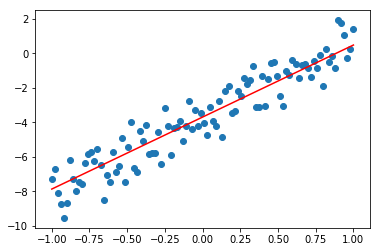

In [110]:
# plot fitted model
plt.scatter(x_train, y_train)
y_fitted = x_train * weight + bias
plt.plot(x_train, y_fitted, 'r')
plt.show()